In [1]:
import argparse
from typing import Dict, List, Tuple

import numpy as np
from matplotlib import pyplot as plt

import xgboost as xgb

In [ ]:
%matplotlib inline

In [2]:
def plot_predt(y: np.ndarray, y_predt: np.ndarray, name: str) -> None:
    s = 25
    plt.scatter(y[:, 0], y[:, 1], c="navy", s=s, edgecolor="black", label="data")
    plt.scatter(
        y_predt[:, 0], y_predt[:, 1], c="cornflowerblue", s=s, edgecolor="black"
    )
    plt.xlim([-1, 2])
    plt.ylim([-1, 2])
    plt.show()

In [3]:
def gen_circle() -> Tuple[np.ndarray, np.ndarray]:
    "Generate a sample dataset that y is a 2 dim circle."
    rng = np.random.RandomState(1994)
    X = np.sort(200 * rng.rand(100, 1) - 100, axis=0)
    y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
    y[::5, :] += 0.5 - rng.rand(20, 2)
    y = y - y.min()
    y = y / y.max()
    return X, y

In [4]:
def rmse_model(plot_result: bool):
    """Draw a circle with 2-dim coordinate as target variables."""
    X, y = gen_circle()
    # Train a regressor on it
    reg = xgb.XGBRegressor(tree_method="hist", n_estimators=64)
    reg.fit(X, y, eval_set=[(X, y)])

    y_predt = reg.predict(X)
    if plot_result:
        plot_predt(y, y_predt, "multi")

In [5]:
def custom_rmse_model(plot_result: bool) -> None:
    """Train using Python implementation of Squared Error."""

    # As the experimental support status, custom objective doesn't support matrix as
    # gradient and hessian, which will be changed in future release.
    def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        """Compute the gradient squared error."""
        y = dtrain.get_label().reshape(predt.shape)
        return (predt - y).reshape(y.size)

    def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        """Compute the hessian for squared error."""
        return np.ones(predt.shape).reshape(predt.size)

    def squared_log(
        predt: np.ndarray, dtrain: xgb.DMatrix
    ) -> Tuple[np.ndarray, np.ndarray]:
        grad = gradient(predt, dtrain)
        hess = hessian(predt, dtrain)
        return grad, hess

    def rmse(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
        y = dtrain.get_label().reshape(predt.shape)
        v = np.sqrt(np.sum(np.power(y - predt, 2)))
        return "PyRMSE", v

    X, y = gen_circle()
    Xy = xgb.DMatrix(X, y)
    results: Dict[str, Dict[str, List[float]]] = {}
    # Make sure the `num_target` is passed to XGBoost when custom objective is used.
    # When builtin objective is used, XGBoost can figure out the number of targets
    # automatically.
    booster = xgb.train(
        {
            "tree_method": "hist",
            "num_target": y.shape[1],
        },
        dtrain=Xy,
        num_boost_round=100,
        obj=squared_log,
        evals=[(Xy, "Train")],
        evals_result=results,
        custom_metric=rmse,
    )

    y_predt = booster.inplace_predict(X)
    if plot_result:
        plot_predt(y, y_predt, "multi")

[0]	validation_0-rmse:0.28597
[1]	validation_0-rmse:0.25494
[2]	validation_0-rmse:0.23359
[3]	validation_0-rmse:0.21640
[4]	validation_0-rmse:0.20574
[5]	validation_0-rmse:0.19311
[6]	validation_0-rmse:0.18435
[7]	validation_0-rmse:0.17502
[8]	validation_0-rmse:0.16830
[9]	validation_0-rmse:0.15957
[10]	validation_0-rmse:0.15430
[11]	validation_0-rmse:0.14604
[12]	validation_0-rmse:0.13629
[13]	validation_0-rmse:0.13249
[14]	validation_0-rmse:0.12557
[15]	validation_0-rmse:0.12198
[16]	validation_0-rmse:0.11972
[17]	validation_0-rmse:0.11345
[18]	validation_0-rmse:0.10926
[19]	validation_0-rmse:0.10367
[20]	validation_0-rmse:0.09938
[21]	validation_0-rmse:0.09543
[22]	validation_0-rmse:0.09302
[23]	validation_0-rmse:0.08848
[24]	validation_0-rmse:0.08575
[25]	validation_0-rmse:0.08280
[26]	validation_0-rmse:0.07694
[27]	validation_0-rmse:0.07375
[28]	validation_0-rmse:0.07137
[29]	validation_0-rmse:0.06737
[30]	validation_0-rmse:0.06433
[31]	validation_0-rmse:0.06239
[32]	validation_0-

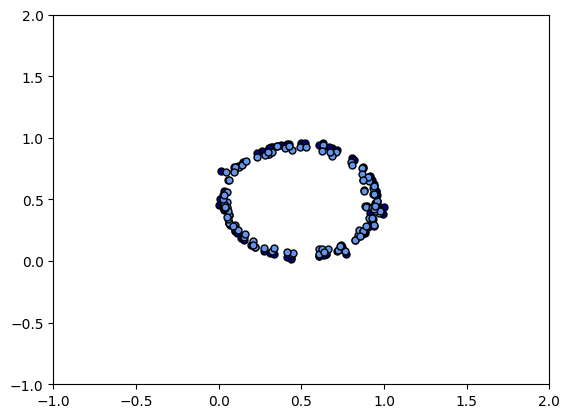

In [6]:
rmse_model(True)

[0]	Train-rmse:0.28597	Train-PyRMSE:4.04424
[1]	Train-rmse:0.25494	Train-PyRMSE:3.60534
[2]	Train-rmse:0.23359	Train-PyRMSE:3.30341
[3]	Train-rmse:0.21640	Train-PyRMSE:3.06038
[4]	Train-rmse:0.20574	Train-PyRMSE:2.90962
[5]	Train-rmse:0.19311	Train-PyRMSE:2.73098
[6]	Train-rmse:0.18435	Train-PyRMSE:2.60710
[7]	Train-rmse:0.17502	Train-PyRMSE:2.47516
[8]	Train-rmse:0.16830	Train-PyRMSE:2.38017
[9]	Train-rmse:0.15957	Train-PyRMSE:2.25667
[10]	Train-rmse:0.15430	Train-PyRMSE:2.18211
[11]	Train-rmse:0.14604	Train-PyRMSE:2.06533
[12]	Train-rmse:0.13629	Train-PyRMSE:1.92740
[13]	Train-rmse:0.13249	Train-PyRMSE:1.87376
[14]	Train-rmse:0.12557	Train-PyRMSE:1.77588
[15]	Train-rmse:0.12198	Train-PyRMSE:1.72505
[16]	Train-rmse:0.11972	Train-PyRMSE:1.69314
[17]	Train-rmse:0.11345	Train-PyRMSE:1.60444
[18]	Train-rmse:0.10926	Train-PyRMSE:1.54524
[19]	Train-rmse:0.10367	Train-PyRMSE:1.46616
[20]	Train-rmse:0.09938	Train-PyRMSE:1.40550
[21]	Train-rmse:0.09543	Train-PyRMSE:1.34963
[22]	Train-rmse:0.09

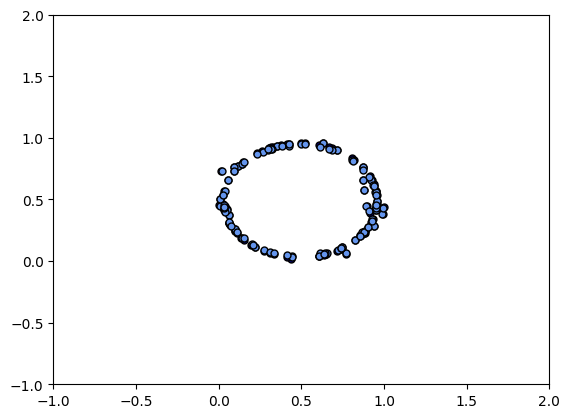

In [7]:
custom_rmse_model(True)